### MÁSTER UNIVERSITARIO EN CIENCIA DE DATOS E INGENIERÍA DE COMPUTADORES
### Trabajo Fin de Máster 2024
##### Detección temprana del trastorno del espectro autista mediante inteligencia artificial confiable
##### Alumno: *Carlos Santiago Sánchez Muñoz*, Tutor: *Alberto Fernández Hilario*

En este cuaderno se va a realizar el aprendizaje del dataset utilizando herramientas de *Deep Learning*.

https://www.tensorflow.org/tutorials/images/classification?hl=es-419

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import imgaug.augmenters as iaa

In [2]:
PATH_TRAIN_POSITIVE = "C:/Users/Carlos/Downloads/TFM_data/Train/TSImages/"
PATH_TRAIN_NEGATIVE = "C:/Users/Carlos/Downloads/TFM_data/Train/TCImages/"
PATH_TEST_POSITIVE = "C:/Users/Carlos/Downloads/TFM_data/Test/TSImages/"
PATH_TEST_NEGATIVE = "C:/Users/Carlos/Downloads/TFM_data/Test/TCImages/"

PATH_RESULT_POSITIVE = "C:/Users/Carlos/Downloads/TFM_data/Result/TSImages/"
PATH_RESULT_NEGATIVE = "C:/Users/Carlos/Downloads/TFM_data/Result/TCImages/"
EXAMPLES_POSITIVE = ["TS032_11.png", "TS046_15.png"]
EXAMPLES_NEGATIVE = ["TC028_30.png", "TC046_37.png", "TC055_30.png"]

IMAGE_EXTENSION = ".png"
NROW = 128   # Alto al que redimensionar
NCOL = 128   # Ancho al que redimensionar
CHANNELS = 3 # Canales: color o B/N
NDEC = 3     # Redondeo de decimales en resultados

MODEL = "DL"
THRESHOLD = 0.6
CLASSES_MP = ["Non ASD", "Low", "Mild", "Severe"]
NUM_AUGMENTATIONS = 4

In [3]:
path = 'C:/Users/Carlos/Downloads/TFM_data/'

# Lee el archivo CSV con los metadatos y lo guarda en un DataFrame
metadata = pd.read_csv(path + 'Metadata/Metadata_Participants.csv')

# Muestra las primeras filas del DataFrame
print(metadata.head())

   ParticipantID Gender Date of Presentation  Age Class  CARS Score
0              1      M           27/04/2015  7.0    TS        32.5
1              2      F           28/04/2015  8.9    TS        36.5
2              3      M           28/04/2015  4.4    TS        27.0
3              4      M           29/04/2015  6.9    TS        35.0
4              5      M           06/05/2015  8.9    TS        31.0


In [4]:
def preprocess_image(image: np.array) -> np.array:
    """
        Preprocesa las imágenes: convierte a gris y cambia el tamaño.

        Parameters:
            image (np.array): imagen a preprocesar

        Returns:
            np.array: image preprocesada
    """
    #print("Tamaño de image: " + str(image.shape))
    # Obtenemos una versión en nivel de gris
    #gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #print("Tamaño de image en gris: " + str(gris.shape))
    # Redimensionar la image al nuevo tamaño
    return cv2.resize(image, (NCOL, NROW))

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(
        rotate=(-20, 20),
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        scale=(0.9, 1.1)
    ),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0, 0.5))
])

def augment_instance(instance: np.ndarray) -> np.ndarray:
    """
    Aplica augmentations a una instancia de datos.

    Parameters:
        instance (np.ndarray): La instancia de datos a ser aumentada.

    Returns:
        np.ndarray: La instancia de datos aumentada.
    """
    return augmentation(image=instance)

def load_data(path_pos: str, path_neg: str, n_augmentations: int=0):
    images = []
    classes = []
    ids = []

    # Casos positivos
    counter_positive_samples = 0
    for filename in os.listdir(path_pos):
        if filename.endswith(IMAGE_EXTENSION):
            img_list = []
            img_list.append(cv2.imread(path_pos + filename))
            the_id = int(filename.split('_')[1].split('.')[0])

            for _ in range(n_augmentations):
                img_list.append(augment_instance(img_list[0]))
                #augmented = next(datagen.flow(img_list[0], batch_size=1))
                #print(augmented.shape)
                #augmented_images.append(augmented[0])
                #.reshape((100, 100))

            for img in img_list:
                img = preprocess_image(img)
                images.append(img)
                classes.append(1)
                ids.append(the_id)
                counter_positive_samples += 1
    
    print("Leidas " + str(counter_positive_samples) + " imágenes -> positivas")

    # Casos negativos
    counter_negative_samples = 0
    for filename in os.listdir(path_neg):
        if filename.endswith(IMAGE_EXTENSION):
            img_list = []
            img_list.append(cv2.imread(path_neg + filename))
            the_id = int(filename.split('_')[1].split('.')[0])
            
            for _ in range(n_augmentations):
                img_list.append(augment_instance(img_list[0]))
                #augmented = next(datagen.flow(img_list[0], batch_size=1))
                #print(augmented.shape)
                #augmented_images.append(augmented[0])
                #.reshape((100, 100))
            
            for img in img_list:
                img = preprocess_image(img)
                images.append(img)
                classes.append(0)
                ids.append(the_id)
                counter_negative_samples += 1
    
    print("Leidas " + str(counter_negative_samples) + " imágenes -> negativas")

    return np.array(images), np.array(classes), np.array(ids)

def calculate_ratio(pred: list[int], ids: list[int]) -> dict:
    """
    Calcula el ratio (promedio) de predicciones postivas para cada id.
    
    Parameters:
        pred (list[int]): predicciones
        ids (list[int]): identificadores
    
    Returns:
        dict: ratios
    """
    if len(pred) != len(ids):
        raise ValueError("Las listas 'pred' e 'ids' deben tener la misma longitud.")
    
    count_dict = {}
    sum_dict = {}
    
    for p, i in zip(pred, ids):
        if i not in count_dict:
            count_dict[i] = 0
            sum_dict[i] = 0
        count_dict[i] += 1
        sum_dict[i] += p
    
    result = {}
    for i in count_dict:
        result[i] = sum_dict[i] / count_dict[i]
    
    return result

def calculate_max(pred: list[int], ids: list[int]) -> dict:
    """
    Calcula el valor máximo de predicciones para cada id.
    
    Parameters:
        pred (list[int]): predicciones
        ids (list[int]): identificadores
    
    Returns:
        dict: máximos valores para cada id
    """
    if len(pred) != len(ids):
        raise ValueError("Las listas 'pred' e 'ids' deben tener la misma longitud.")
    
    max_dict = {}
    
    for p, i in zip(pred, ids):
        if i not in max_dict:
            max_dict[i] = p
        else:
            if p > max_dict[i]:
                max_dict[i] = p
    
    return max_dict

def thresholding(dict: dict, threshold: float=0.2) -> dict:
    """
    Umbraliza a partir de un límite dado.
    
    Parameters:
        dict: diccionario de valores
        threshold: límite para la umbralización
    
    Returns:
        int dictonary: diccionario umbralizado
    """ 
    for clave, valor in dict.items():
        if valor > threshold:
            dict[clave] = 1
        else:
            dict[clave] = 0
    
    return dict

def thresholding_new(dict: dict, threshold: list[float]=[0.2], labels:list[int]=[0,1]) -> dict:
    """
    Umbraliza a partir de un límite dado.
    
    Parameters:
        dict: diccionario de valores
        threshold: límites para la umbralización
        labels: etiquetas
    
    Returns:
        int dictonary: diccionario umbralizado
    """ 
    for clave, valor in dict.items():
        for i in range(len(threshold)):
            if(valor<threshold[i]):
                dict[clave] = labels[i]
                break
            elif(i==(len(threshold)-1)):
                dict[clave] = labels[i+1]
    
    return dict

def confusion_matrix_customized(y_train:list[int], y_pred: list[int],title: str='Confusion Matrix',
                                classes: list[str]=['TD', 'ASD']) -> np.ndarray:
    """
    Genera una imagen con la matriz de confusión.
    
    Parameters:
        y_train (list[int]): clases reales del conjunto de train.
        y_pred (list[str]): estimaciones del clasificador.
        title (str): title of the plot. By default, 'Confusion Matrix'.
        classes (list[str]): classes label. By default, ['TD', 'ASD'].
    
    Returns:
        np.ndarray: confusion matrix
    """
    conf_matrix = metrics.confusion_matrix(y_train, y_pred)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(6,5))
    # Scale up the size of all text
    sns.set(font_scale = 1.3)
    # Plot Confusion Matrix using Seaborn heatmap()
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d') # cmap="Blues"
    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(classes)
    # set y-axis label and ticks
    ax.set_ylabel("Actual", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(classes)
    # set plot title
    ax.set_title(title, fontsize=14, pad=20)

    plt.show()

    return conf_matrix

def results(y_test: list[int], y_pred: list[int], title:str = 'Confusion matrix',
            classes: list[str]=['TD', 'ASD']) -> tuple[float, float, float, float, float]:
    """
    Calculates some metrics for the preditions obtained.
    It plots a confusion  matix.
    
    Parameters:
        y_test: real classes.
        y_pred: predicions of the classifier..
        title (str): title of the plot. By default, 'Confusion Matrix'..
    
    Returns:
        float: accuracy
        float: precision
        float: sensitivity_recall
        float: specificity
        float: F1_score
    """
    accuracy = metrics.accuracy_score(y_test, y_pred).round(NDEC)
    precision = metrics.precision_score(y_test, y_pred).round(NDEC)
    sensitivity_recall = metrics.recall_score(y_test, y_pred).round(NDEC)
    specificity = metrics.recall_score(y_test, y_pred, pos_label=0).round(NDEC)
    F1_score = metrics.f1_score(y_test, y_pred).round(NDEC)

    print({"Accuracy":accuracy, "Precision":precision, "Sensitivity_recall":sensitivity_recall,
           "Specificity":specificity,"F1_score":F1_score})
    
    confusion_matrix_customized(y_test, y_pred, title, classes)
    
    return accuracy, precision, sensitivity_recall, specificity, F1_score

def change_MIL(y_test:list[int], y_pred:list[int], IDS:list[int], verbose:bool=False) -> tuple[list[int], list[int]]:
    """
    Calcula el ratio de predecciones postivas para cada id.
    
    Parameters:
        y_test (list[int]): real classes.
        y_pred (list[int]): predicions of the classifier.
        ids (list[int]): identificadores
    
    Returns:
        tuple[list[int], list[int]]: ratios
    """
    #y_pred_ratio = calculate_max(y_pred, IDS)
    y_pred_ratio = calculate_ratio(y_pred, IDS)
    if(verbose):
        print(list(y_pred_ratio.values()))
    y_pred_ratio = thresholding(y_pred_ratio, THRESHOLD)
    y_pred_ratio = list(y_pred_ratio.values())
    y_test_ratio = calculate_ratio(y_test, IDS)
    y_test_ratio = [int(val) for val in y_test_ratio.values()]

    return y_test_ratio, y_pred_ratio

def change_MIL_multiclass(y_test:list[int], y_pred:list[int], IDS:list[int], verbose:bool=False) -> tuple[list[int], list[int]]:
    """
    Calcula el ratio de predecciones postivas para cada id.
    
    Parameters:
        y_test (list[int]): real classes.
        y_pred (list[int]): predicions of the classifier.
        ids (list[int]): identificadores
    
    Returns:
        tuple[list[int], list[int]]: ratios
    """
    y_pred_ratio = calculate_max(y_pred, IDS)
    #y_pred_ratio = calculate_ratio(y_pred, IDS)
    if(verbose):
        print(list(y_pred_ratio.values()))
    #y_pred_ratio = thresholding_new(y_pred_ratio, [0.45, 1.0, 2.5], [0,1,2,3])
    y_pred_ratio = list(y_pred_ratio.values())
    y_test_ratio = calculate_max(y_test, IDS)
    y_test_ratio = [int(val) for val in y_test_ratio.values()]

    return y_test_ratio, y_pred_ratio

In [5]:
X_train, y_train, IDs_train = load_data(PATH_TRAIN_POSITIVE, PATH_TRAIN_NEGATIVE, NUM_AUGMENTATIONS)
X_test, y_test, IDs_test = load_data(PATH_TEST_POSITIVE, PATH_TEST_NEGATIVE)

print("Instancias para entrenamiento: " + str(X_train.shape))
print("Instancias para test: " + str(X_test.shape))

Leidas 915 imágenes -> positivas
Leidas 1485 imágenes -> negativas
Leidas 36 imágenes -> positivas
Leidas 31 imágenes -> negativas
Instancias para entrenamiento: (2400, 128, 128, 3)
Instancias para test: (67, 128, 128, 3)


In [6]:
if(False):
    for i in range(len(X_train)):
        img = X_train[i].reshape((1, 100, 100, 1))
        label = y_train[i]
        img_id = IDs_train[i]
        
        for _ in range(NUM_AUGMENTATIONS):
            augmented = next(datagen.flow(img, batch_size=1))
            augmented_images.append(augmented[0].reshape((100, 100)))
            augmented_labels.append(label)
            augmented_ids.append(img_id)

In [11]:
# Definir y compilar la red neuronal
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(NROW, NCOL, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    #Dense(1, activation='sigmoid')
    Dense(2, activation='softmax')
])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=4, batch_size=32)

c:\Users\Carlos\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 298ms/step - accuracy: 0.6274 - loss: 2.0102
Epoch 2/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 279ms/step - accuracy: 0.8086 - loss: 0.4426
Epoch 3/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.8969 - loss: 0.2630
Epoch 4/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.9499 - loss: 0.1478


In [163]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")
print(f"Test loss: {test_loss:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7940 - loss: 0.5673 
Test accuracy: 0.79
Test loss: 0.62


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
{'Accuracy': 0.992, 'Precision': 0.998, 'Sensitivity_recall': 0.98, 'Specificity': 0.999, 'F1_score': 0.989}


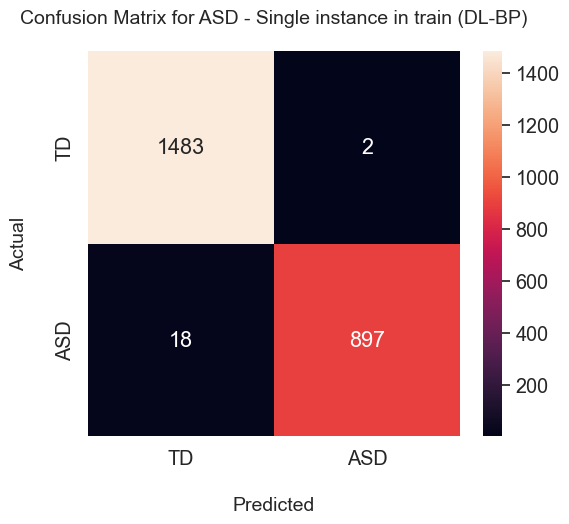

{'Accuracy': 0.952, 'Precision': 0.909, 'Sensitivity_recall': 1.0, 'Specificity': 0.909, 'F1_score': 0.952}


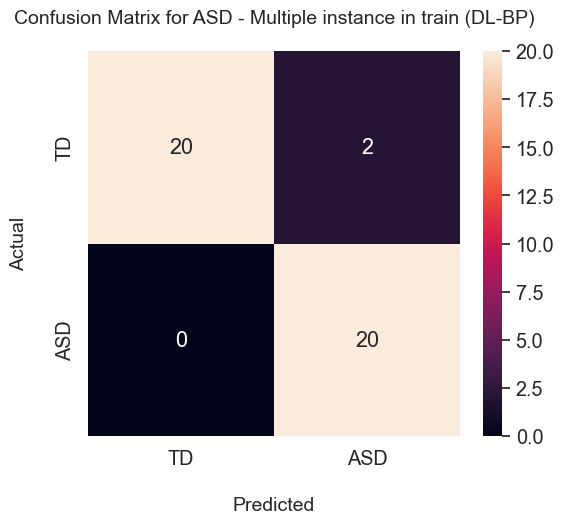

(0.952, 0.909, 1.0, 0.909, 0.952)

In [166]:
THRESHOLD=0.45
# Realizamos predicciones sobre el conjunto de train
y_pred = model.predict(X_train).flatten()
y_pred = (y_pred >= 0.5).astype(int)

y_train_ratio, y_pred_ratio = change_MIL(y_train, y_pred, IDs_train, True)
if(False):
    print(y_pred)
    print(y_train)
    print(y_pred_ratio)
    print(y_train_ratio)

results(y_train, y_pred, "Confusion Matrix for ASD - Single instance in train (" + MODEL + "-BP)")
results(y_train_ratio, y_pred_ratio, "Confusion Matrix for ASD - Multiple instance in train (" + MODEL + "-BP)")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step 
[1.0, 1.0, 0.5454545454545454, 0.8, 1.0, 0.6666666666666666, 0.25, 0.125, 0.0, 0.2857142857142857, 0.0, 0.2857142857142857]
{18: 1, 9: 1, 5: 1, 8: 1, 16: 1, 23: 1, 31: 0, 48: 0, 55: 0, 53: 0, 56: 0, 38: 0}
{'Accuracy': 0.791, 'Precision': 0.824, 'Sensitivity_recall': 0.778, 'Specificity': 0.806, 'F1_score': 0.8}


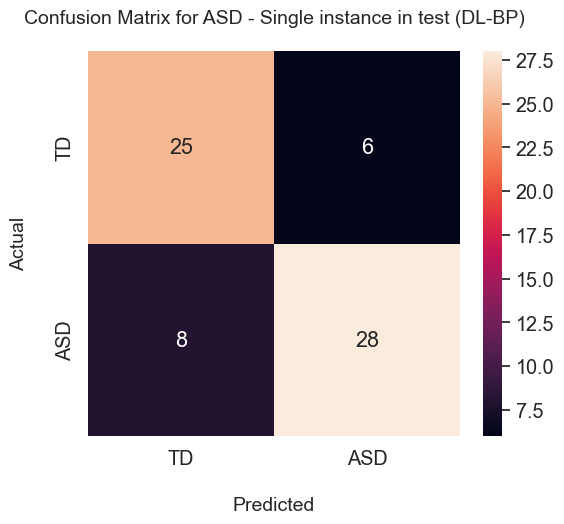

{'Accuracy': 1.0, 'Precision': 1.0, 'Sensitivity_recall': 1.0, 'Specificity': 1.0, 'F1_score': 1.0}


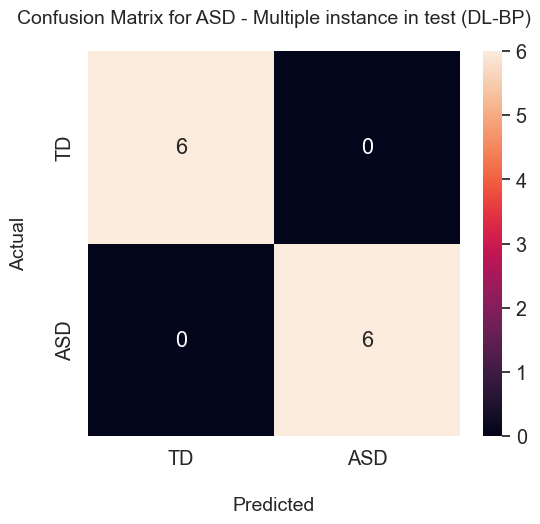

(1.0, 1.0, 1.0, 1.0, 1.0)

In [226]:
# Realizamos predicciones sobre el conjunto de test
y_pred = model.predict(X_test).flatten()
y_pred = (y_pred >= 0.5).astype(int)

y_pred_ratio = calculate_ratio(y_pred, IDs_test)
print(list(y_pred_ratio.values()))
y_pred_ratio = thresholding(y_pred_ratio, THRESHOLD)
print(y_pred_ratio)
y_pred_df = pd.DataFrame(list(y_pred_ratio.items()), columns=['ParticipantID', 'pred_BP'])
#metadata = pd.merge(metadata, y_pred_df, on='ParticipantID', how='left')

y_pred_ratio = list(y_pred_ratio.values())
y_test_ratio = calculate_ratio(y_test, IDs_test)
y_test_ratio = [int(val) for val in y_test_ratio.values()]

#y_test_ratio, y_pred_ratio = change_MIL(y_test, y_pred, IDs_test)

results(y_test, y_pred, "Confusion Matrix for ASD - Single instance in test (" + MODEL + "-BP)")
results(y_test_ratio, y_pred_ratio, "Confusion Matrix for ASD - Multiple instance in test (" + MODEL + "-BP)")

Utilizando los valores probabilísticos que arroja la función sigmoidal.

75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step
{11: 0.946741, 20: 0.97056174, 19: 0.9817177, 27: 0.98595065, 15: 0.99334884, 17: 0.9967782, 7: 0.98525983, 13: 0.95751995, 14: 0.95649153, 22: 0.7211855, 24: 0.82798594, 10: 0.888139, 3: 0.8801139, 1: 0.9224383, 6: 0.910666, 2: 0.9391182, 4: 0.9819301, 29: 0.98543197, 28: 0.99720496, 12: 0.9835513, 39: 0.03336328, 37: 0.04043556, 33: 0.039947607, 52: 0.038751293, 54: 0.04470375, 30: 0.038726605, 36: 0.05634777, 40: 0.0514145, 35: 0.025306929, 34: 0.059548896, 50: 0.030521622, 43: 0.042780742, 49: 0.04547047, 51: 0.042188723, 47: 0.04882039, 57: 0.032110613, 59: 0.052711, 32: 0.033592094, 46: 0.055148505, 45: 0.058627557, 44: 0.042867232, 58: 0.026734587}
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Final accuracy: 1.00
{'Accuracy': 1.0, 'Precision': 1.0, 'Sensitivity_recall': 1.0, 'Specificity': 1.0, 'F1_score': 1.0}


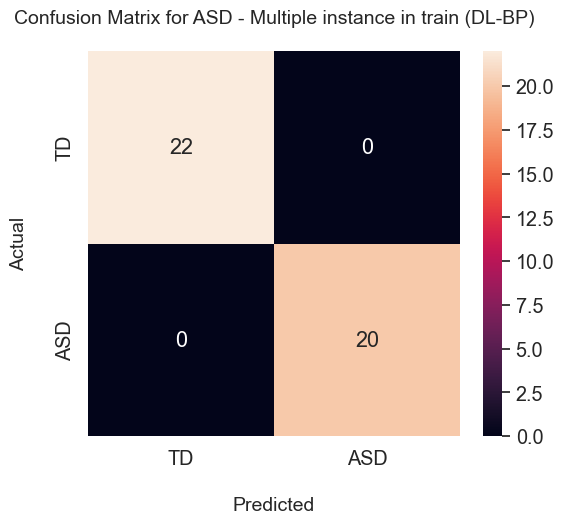

(1.0, 1.0, 1.0, 1.0, 1.0)

In [168]:
# MIL: agrupar las predicciones por ID
preds = model.predict(X_train).flatten()
id_preds = {}
for i in range(len(preds)):
    if IDs_train[i] not in id_preds:
        id_preds[IDs_train[i]] = []
    id_preds[IDs_train[i]].append(preds[i])

# Calcular la predicción final por ID
y_preds_2 = {k: np.mean(v) for k, v in id_preds.items()}
print(y_preds_2)
y_preds_2 = {k: 1 if v >= THRESHOLD else 0 for k, v in y_preds_2.items()}
y_preds_2 = list(y_preds_2.values())
print(y_preds_2)

# Evaluar las predicciones finales
print(f"Final accuracy: {accuracy_score(y_train_ratio, y_preds_2):.2f}")
results(y_train_ratio, y_preds_2, "Confusion Matrix for ASD - Multiple instance in train (" + MODEL + "-BP)")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step 
{18: 0.9558205, 9: 0.9788165, 5: 0.5432796, 8: 0.7462879, 16: 0.9563612, 23: 0.6365209, 31: 0.25352937, 48: 0.24290402, 55: 0.023810282, 53: 0.35394296, 56: 0.028822193, 38: 0.33991787}
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Final accuracy: 1.00
{'Accuracy': 1.0, 'Precision': 1.0, 'Sensitivity_recall': 1.0, 'Specificity': 1.0, 'F1_score': 1.0}


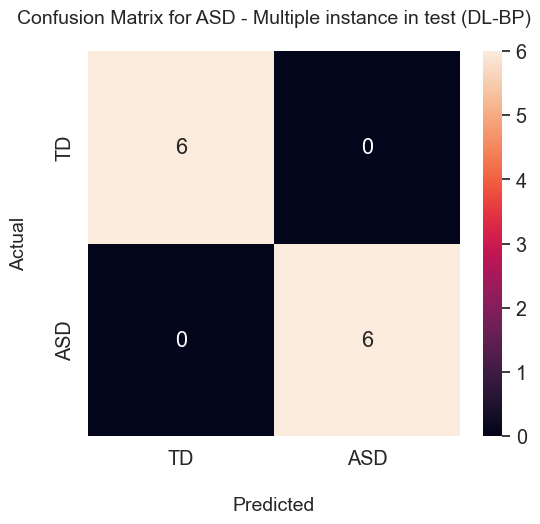

(1.0, 1.0, 1.0, 1.0, 1.0)

In [169]:
# MIL: agrupar las predicciones por ID
preds = model.predict(X_test).flatten()
id_preds = {}
for i in range(len(preds)):
    if IDs_test[i] not in id_preds:
        id_preds[IDs_test[i]] = []
    id_preds[IDs_test[i]].append(preds[i])

# Calcular la predicción final por ID
y_preds_2 = {k: np.mean(v) for k, v in id_preds.items()}
print(y_preds_2)
y_preds_2 = {k: 1 if v >= THRESHOLD else 0 for k, v in y_preds_2.items()}
y_preds_2 = list(y_preds_2.values())
print(y_preds_2)

# Evaluar las predicciones finales
print(f"Final accuracy: {accuracy_score(y_test_ratio, y_preds_2):.2f}")
results(y_test_ratio, y_preds_2, "Confusion Matrix for ASD - Multiple instance in test (" + MODEL + "-BP)")

# IA Confiable

## Explainability: detección en la imagen



Repositorio oficial de [Keras para Grad-CAM](https://keras.io/examples/vision/grad_cam/)

In [7]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

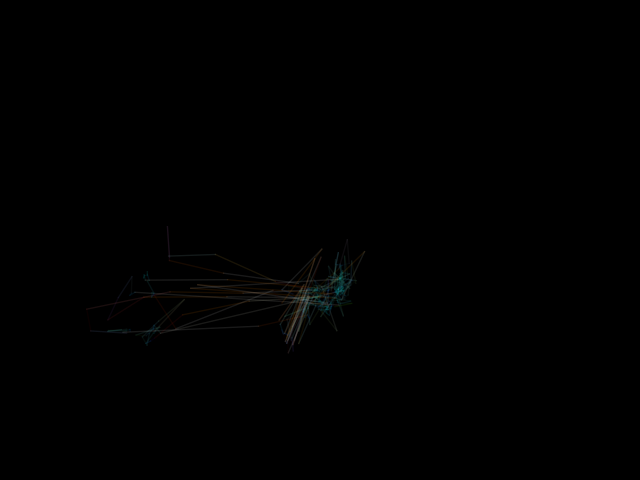

In [17]:
img_size = (NROW, NCOL)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_1"

img_path = PATH_TRAIN_POSITIVE + EXAMPLES_POSITIVE[1]
#img_path = PATH_TRAIN_NEGATIVE + EXAMPLES_NEGATIVE[0]
display(Image(img_path))

In [19]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform into a "batch" of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.layers[-1].output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(preds)
        if pred_index is None:
            print(preds)
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[-0.17800727  0.6114642 ]]
tf.Tensor([[-0.17800727  0.6114642 ]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.17800727  0.6114642 ]], shape=(1, 2), dtype=float32)


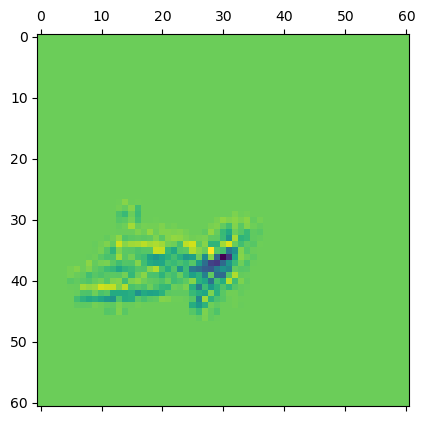

In [20]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
value_to_replace = 0.68

# Reemplazar el valor en el heatmap
#heatmap = np.where(heatmap < value_to_replace, 0.1, heatmap)
#print(heatmap)

# Display heatmap
plt.matshow(heatmap)
plt.show()

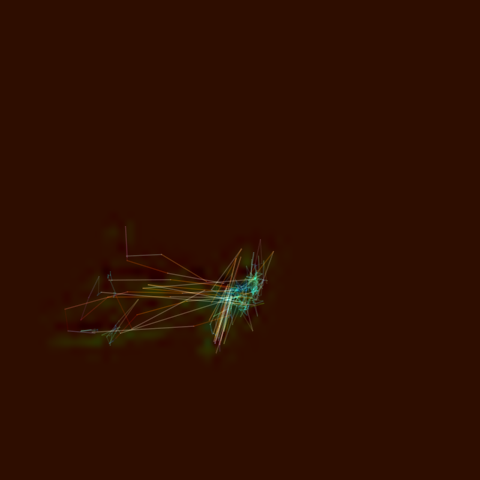

In [21]:
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.1):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img = superimposed_img.resize((480, 480))

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

save_and_display_gradcam(img_path, heatmap, PATH_RESULT_POSITIVE + "GRAD-CAM_" + EXAMPLES_POSITIVE[0])

## Fairness

Con el objetivo de mejorar la equidad se van a tener en cuenta las siguientes métricas de equidad.

In [6]:
def disparate_impact(y_pred: list[int], protected_attribute: list[int], privileged_group: int = 1) -> float:
    """
    Calculates disparate impact.

    Parameters:
        y_pred (list[int]): Model predictions.
        y_true (list[int]): True values.
        protected_attribute (list[int]): Protected attribute (e.g., gender).
        privileged_group (int): Privileged group (value of the protected attribute).

    Returns:
        float: Disparate impact value. Values close to 1 indicate greater fairness.
    """
    y_pred = np.array(y_pred)
    protected_attribute = np.array(protected_attribute)

    privileged_positive_rate = (
        np.sum((y_pred == 1) & (protected_attribute == privileged_group)) /
        np.sum(protected_attribute == privileged_group))
    unprivileged_positive_rate = (
        np.sum((y_pred == 1) & (protected_attribute != privileged_group)) /
        np.sum(protected_attribute != privileged_group))

    if(privileged_positive_rate!=0):
        disparate_impact_value = unprivileged_positive_rate / (privileged_positive_rate)
    else:
        disparate_impact_value = 0
        raise ValueError("Privileged postive rate is 0.")

    return disparate_impact_value

def demographic_parity(y_pred: list[int], protected_attribute: list[int], privileged_group: int = 1) -> float:
    """
    Calculates demographic parity.

    Parameters:
        y_pred (list[int]): Model predictions.
        protected_attribute (list[int]): Protected attribute (e.g., gender).
        privileged_group (int): Privileged group (value of the protected attribute).

    Returns:
        float: Demographic parity value. Lower values indicate more similar acceptance rates and thus greater fairness.
    """
    y_pred = np.array(y_pred)
    protected_attribute = np.array(protected_attribute)

    privileged_positive_rate = (
        np.sum((y_pred == 1) & (protected_attribute == privileged_group)) /
        np.sum(protected_attribute == privileged_group))
    unprivileged_positive_rate = (
        np.sum((y_pred == 1) & (protected_attribute != privileged_group)) /
        np.sum(protected_attribute != privileged_group))

    demographic_parity_value = privileged_positive_rate - unprivileged_positive_rate

    return demographic_parity_value

def equalized_odds(y_pred: list[int], y_true: list[int], protected_attribute: list[int],
                   privileged_group: int = 1) -> tuple[float, float]:
    """
    Calculates equalized odds.

    Parameters:
        y_pred (list[int]): Model predictions.
        y_true (list[int]): True values.
        protected_attribute (list[int]): Protected attribute (e.g., gender).
        privileged_group (int): Privileged group (value of the protected attribute).

    Returns:
        dict: Dictionary with FPR and TPR differences. Lower values indicate greater fairness.
    """
    # Convert lists to numpy arrays for ease of manipulation
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    protected_attribute = np.array(protected_attribute)

    # Calculate FPR and TPR for the privileged group
    priv_negatives = (y_true == 0) & (protected_attribute == privileged_group)
    priv_positives = (y_true == 1) & (protected_attribute == privileged_group)
    priv_fpr = np.sum((y_pred == 1) & priv_negatives) / np.sum(priv_negatives)
    priv_tpr = np.sum((y_pred == 1) & priv_positives) / np.sum(priv_positives)

    # Calculate FPR and TPR for the unprivileged group
    unpriv_negatives = (y_true == 0) & (protected_attribute != privileged_group)
    unpriv_positives = (y_true == 1) & (protected_attribute != privileged_group)
    unpriv_fpr = np.sum((y_pred == 1) & unpriv_negatives) / np.sum(unpriv_negatives)
    unpriv_tpr = np.sum((y_pred == 1) & unpriv_positives) / np.sum(unpriv_positives)

    # Calculate the differences
    fpr_difference = np.abs(priv_fpr - unpriv_fpr)
    tpr_difference = np.abs(priv_tpr - unpriv_tpr)

    return fpr_difference, tpr_difference


In [227]:
metadata_filtrado = metadata.dropna(subset=['pred_BP'])

y_pred_clean = metadata_filtrado['pred_BP'].tolist()
y_true_clean = metadata_filtrado['Class'].map({'TS': 1, 'TC': 0}).tolist()
y_prot_clean = metadata_filtrado['Gender'].map({'M': 1, 'F': 0}).tolist()

if(True):
    #print(metadata_filtrado)
    print(y_pred_clean)
    print(y_true_clean)
    print(y_prot_clean)

print("Disparate impact: {:.2f}".format(disparate_impact(y_pred_clean, y_prot_clean)))
print("Demographic parity: {:.2f}".format(demographic_parity(y_pred_clean, y_prot_clean)))
print("Equalized_odds: " + str(equalized_odds(y_pred_clean, y_true_clean, y_prot_clean)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]
Disparate impact: 0.40
Demographic parity: 0.38
Equalized_odds: (0.0, 0.0)


## Privacy: Federated Learning

In [12]:
from sklearn.model_selection import StratifiedKFold

def build_model(input_shape: tuple) -> Sequential:
    """
    Construye y compila un modelo de red neuronal convolucional.

    Parameters:
        input_shape (tuple): La forma de entrada de los datos, e.g., (128, 128, 3).

    Returns:
        Sequential: El modelo de red neuronal compilado.
    """
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_local_model(X_train_local: np.ndarray, y_train_local: np.ndarray,
                      input_shape: tuple) -> Sequential:
    """
    Entrena un modelo de red neuronal local en los datos locales.

    Parameters:
        X_train_local (np.ndarray): Datos de entrenamiento locales.
        y_train_local (np.ndarray): Etiquetas de entrenamiento locales.
        input_shape (tuple): Forma de entrada de los datos.

    Returns:
        Sequential: El modelo de red neuronal entrenado.
    """
    model = build_model(input_shape)
    model.fit(X_train_local, y_train_local, epochs=4, batch_size=32, verbose=0)

    return model

def train_local_model_OLD(X_train_local: np.ndarray, y_train_local: np.ndarray) -> Sequential:
    """
    Entrena un modelo de red neuronal local en los datos locales.

    Parameters:
        X_train_local (np.ndarray): Datos de entrenamiento locales.
        y_train_local (np.ndarray): Etiquetas de entrenamiento locales.

    Returns:
        Sequential: El modelo de red neuronal entrenado.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(NROW, NCOL, CHANNELS)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_local, y_train_local, epochs=4, batch_size=32, verbose=0)
    return model

def average_predictions(models: list[Sequential], X_test: np.ndarray) -> np.ndarray:
    """
    Combina las predicciones de los modelos locales usando el promedio de probabilidades.

    Parameters:
        models (list[Sequential]): Lista de modelos de red neuronal entrenados.
        X_test (np.ndarray): Datos de prueba.

    Returns:
        np.ndarray: Predicciones combinadas.
    """
    probs = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        probs[:, i] = model.predict(X_test).flatten()

    avg_probs = np.mean(probs, axis=1)
    return np.where(avg_probs > 0.5, 1, 0)

def evaluate_global_model(global_predictions: np.ndarray, y_test: np.ndarray) -> float:
    """
    Evalúa la precisión del modelo global en el conjunto de datos de prueba.

    Parameters:
        global_predictions (np.ndarray): Predicciones del modelo global.
        y_test (np.ndarray): Etiquetas reales de prueba.

    Returns:
        float: Precisión del modelo global.
    """
    accuracy = accuracy_score(y_test, global_predictions)
    return accuracy

def federated_learning(X_train_global: np.ndarray, y_train_global: np.ndarray,
                       X_test: np.ndarray, y_test: np.ndarray, IDs_train: np.ndarray,
                       num_devices: int, num_rounds: int) -> float:
    """
    Entrena un modelo global utilizando Aprendizaje Federado y evalúa su precisión.

    Parameters:
        X_train_global (np.ndarray): Datos de entrenamiento globales.
        y_train_global (np.ndarray): Etiquetas de entrenamiento globales.
        X_test (np.ndarray): Datos de prueba.
        y_test (np.ndarray): Etiquetas de prueba.
        IDs_train (np.ndarray): Identificadores de las instancias.
        num_devices (int): Número de dispositivos.
        num_rounds (int): Número de rondas de entrenamiento.

    Returns:
        float: Precisión del modelo global.
    """
    skf = StratifiedKFold(n_splits=num_devices)

    id_to_label = {}
    for id, label in zip(IDs_train, y_train_global):
        if id not in id_to_label:
            id_to_label[id] = label
    
    unique_ids = list(id_to_label.keys())
    labels = list(id_to_label.values())
    
    for round in range(num_rounds):
        print("Round:", round+1)
        local_models = []
        i=1
        
        # Dividir el conjunto de datos global en dispositivos locales
        for train_index, _ in skf.split(unique_ids, labels):
            print("    Hospital ", i)
            i += 1

            local_ids = [unique_ids[i] for i in train_index]
            local_mask = np.isin(IDs_train, local_ids)
            X_train_local = X_train_global[local_mask]
            y_train_local = y_train_global[local_mask]

            # Entrenar modelos locales en cada dispositivo
            local_model = train_local_model(X_train_local, y_train_local, X_train_global.shape[1:])
            local_models.append(local_model)
        
        # Combinar las predicciones de los modelos locales en el conjunto de prueba
        global_predictions = average_predictions(local_models, X_test)
        
        accuracy = evaluate_global_model(global_predictions, y_test)
        print("    Accuracy on test set:", accuracy)
    
    return local_models

num_devices = 2  # Número de hospitales
num_rounds = 5   # Número de rondas de entrenamiento
local_models = federated_learning(X_train, y_train, X_test, y_test, IDs_train, num_devices, num_rounds)

Round: 1
    Hospital  1
    Hospital  2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
    Accuracy on test set: 0.7910447761194029
Round: 2
    Hospital  1
    Hospital  2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
    Accuracy on test set: 0.7611940298507462
Round: 3
    Hospital  1
    Hospital  2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
    Accuracy on test set: 0.7761194029850746
Round: 4
    Hospital  1
    Hospital  2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
    Accuracy on test set: 0.7164179104477612
Round: 5
    Hospital  1
    Hospital  2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
    Accuracy on test set: 0.7761194029850746


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[1.0, 1.0, 0.2727272727272727, 0.6, 1.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.2857142857142857]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
{'Accuracy': 0.776, 'Precision': 0.889, 'Sensitivity_recall': 0.667, 'Specificity': 0.903, 'F1_score': 0.762}


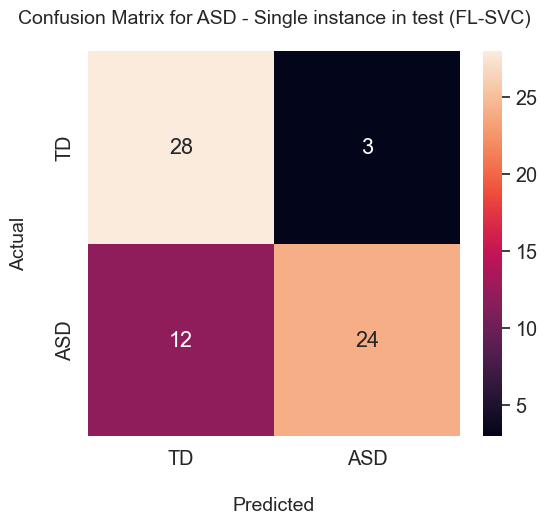

{'Accuracy': 0.917, 'Precision': 1.0, 'Sensitivity_recall': 0.833, 'Specificity': 1.0, 'F1_score': 0.909}


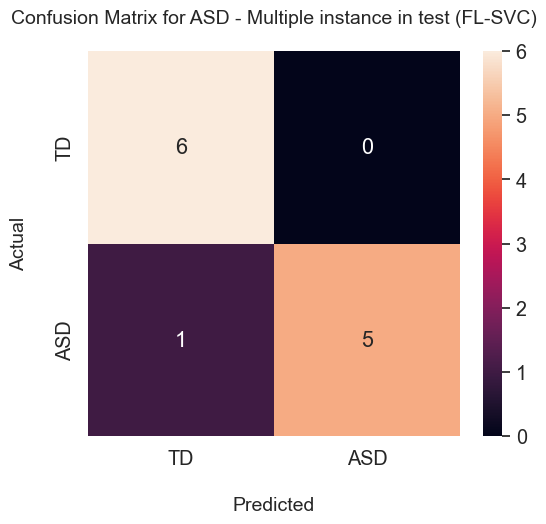

(0.917, 1.0, 0.833, 1.0, 0.909)

In [17]:
THRESHOLD=0.45

# Realizamos predicciones sobre el conjunto de test
y_pred = average_predictions(local_models, X_test)
y_test_ratio, y_pred_ratio = change_MIL(y_test, y_pred, IDs_test, True)
print(y_test_ratio)
print(y_pred_ratio)

results(y_test, y_pred, "Confusion Matrix for ASD - Single instance in test (FL-SVC)")
results(y_test_ratio, y_pred_ratio, "Confusion Matrix for ASD - Multiple instance in test (FL-SVC)")

# Clasificación multiclase

El primer paso es construir las listas con las salidas multiclase, es decir, en vez de ser una clasificación binaria va a ser una clasificación multiclase según grados de severidad. Por tanto, las etiquetas van ahora de 0 a 3.

In [7]:
def get_cars_scores(IDs_train: list[str], metadata: pd.DataFrame) -> list[float]:
    """
    Busca cada ID en el DataFrame metadata y extrae el valor de Cars_Score.

    Parameters:
        IDs_train (list[str]): Lista de IDs a buscar.
        metadata (pd.DataFrame): DataFrame con las columnas 'ParticipantID' y 'CARS Score'.

    Returns:
        list[float]: Lista con los valores de Cars_Score correspondientes a los IDs en IDs_train.
                     Los valores NaN se reemplazan con 0.0.
    """
    cars_scores = []

    for ID in IDs_train:
        score = metadata.loc[metadata['ParticipantID'] == ID, 'CARS Score']
        
        if not score.empty:
            if not pd.isna(score.iloc[0]):
                cars_scores.append(float(score.iloc[0]))
            else:
                cars_scores.append(0.0)
        else:
            print("ID {ID} no se encontró en los metadatos.")

    return cars_scores

def discretize(y_cont: np.ndarray) -> np.ndarray:
    """
    Discretiza un array continuo en clases ordinales basadas en límites predefinidos.

    Parameters:
        y_cont (np.ndarray): Array de valores continuos a discretizar.

    Returns:
        np.ndarray: Array de valores discretizados en clases ordinales.
    """
    bins = [-np.inf, 15, 30, 36.5, np.inf]
    labels = [0, 1, 2, 3]
    y_indices = np.digitize(y_cont, bins) - 1  # np.digitize devuelve índices que empiezan en 1
    y_disc = np.array([labels[idx] for idx in y_indices])

    return y_disc

# Se obtienen los CARS scores a través del csv con los metadatos
y_train_multi = get_cars_scores(IDs_train, metadata)
y_test_multi = get_cars_scores(IDs_test, metadata)

# Se discretizan según el estándar CARS.
y_train_multi_disc = discretize(y_train_multi)
y_test_multi_disc = discretize(y_test_multi)

In [191]:
model_multi = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(NROW, NCOL, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compilar el modelo con la pérdida adecuada para clasificación multiclase
model_multi.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model_multi.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model_multi.fit(X_train, y_train_multi_disc, epochs=4, batch_size=32)
#history = model_multi.fit(X_train, y_train_categorical, epochs=50, batch_size=32)

c:\Users\Carlos\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 445ms/step - accuracy: 0.4933 - loss: 3.8975
Epoch 2/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 442ms/step - accuracy: 0.6824 - loss: 0.8214
Epoch 3/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 638ms/step - accuracy: 0.7781 - loss: 0.6036
Epoch 4/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 70s 466ms/step - accuracy: 0.8530 - loss: 0.3756


In [204]:
def change_MIL_multiclass(y_test:list[int], y_pred:list[int], IDS:list[int], verbose:bool=False) -> tuple[list[int], list[int]]:
    """
    Calcula el ratio de predecciones postivas para cada id.
    
    Parameters:
        y_test (list[int]): real classes.
        y_pred (list[int]): predicions of the classifier.
        ids (list[int]): identificadores
    
    Returns:
        tuple[list[int], list[int]]: ratios
    """
    #y_pred_ratio = calculate_max(y_pred, IDS)
    y_pred_ratio = calculate_ratio(y_pred, IDS)
    if(verbose):
        print(list(y_pred_ratio.values()))
    y_pred_ratio = thresholding_new(y_pred_ratio, [0.5, 1.3, 2.0], [0,1,2,3])
    y_pred_ratio = list(y_pred_ratio.values())
    y_test_ratio = calculate_max(y_test, IDS)
    y_test_ratio = [int(val) for val in y_test_ratio.values()]

    return y_test_ratio, y_pred_ratio

75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step
[[3.4439694e-02 6.1578625e-03 9.8228594e-03 9.4957960e-01]
 [6.4468262e-04 1.9133008e-04 5.1298429e-04 9.9865109e-01]
 [5.6569632e-03 4.3423926e-03 1.2150120e-03 9.8878562e-01]
 ...
 [9.9126524e-01 4.3131793e-03 2.9745954e-03 1.4469011e-03]
 [9.4155383e-01 4.2442504e-02 1.5593467e-02 4.1025796e-04]
 [9.8627591e-01 6.6767316e-03 7.0042056e-03 4.3109310e-05]]
[3 3 3 ... 0 0 0]
[3 3 3 ... 0 0 0]
[2.7818181818181817, 0.9466666666666667, 1.0, 3.0, 2.0, 3.0, 1.92, 0.9454545454545454, 0.94, 1.12, 1.5333333333333334, 0.8133333333333334, 0.8142857142857143, 1.6363636363636365, 0.8615384615384616, 2.742857142857143, 1.9285714285714286, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02857142857142857, 0.0, 0.0]
[3, 1, 1, 3, 2, 3, 2, 1, 1, 2, 2, 1, 1, 2, 1, 3, 2, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 1, 1, 3, 3, 3, 2, 1, 1, 1, 2, 1, 1, 2, 1, 3, 2, 3, 3,

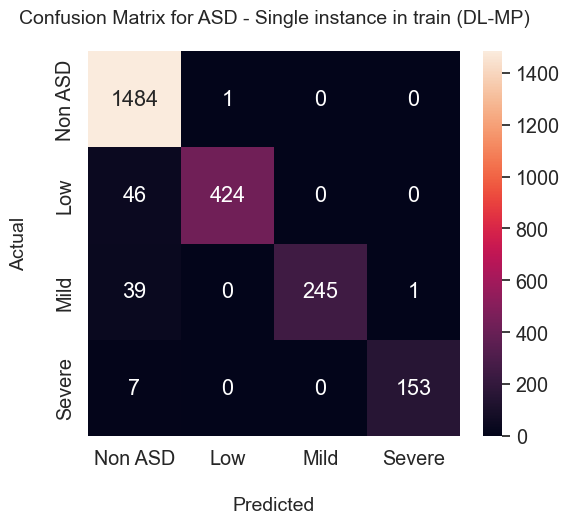

{'Accuracy': 0.952}


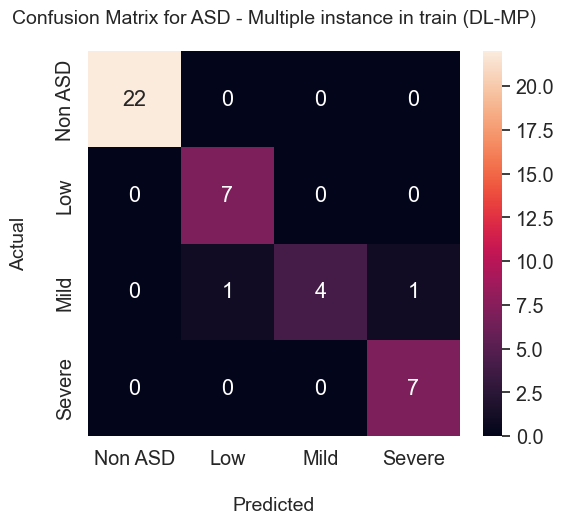

array([[22,  0,  0,  0],
       [ 0,  7,  0,  0],
       [ 0,  1,  4,  1],
       [ 0,  0,  0,  7]], dtype=int64)

In [205]:
y_pred = model_multi.predict(X_train)
print(y_pred)
y_pred = np.argmax(y_pred, axis=1)
#y_pred = (y_pred >= 0.5).astype(int)

# Evaluar el modelo con la función de pérdida personalizada
#loss = custom_loss(y_train_multi_disc, y_pred)
#print(f'Custom loss: {loss}')
print(y_pred)
print(y_train_multi_disc)

y_train_multi_ratio, y_pred_multi_ratio = change_MIL_multiclass(y_train_multi_disc, y_pred, IDs_train, True)
print(y_train_multi_ratio)
print(y_pred_multi_ratio)

print({"Accuracy":metrics.accuracy_score(y_train_multi_disc, y_pred).round(NDEC)})
confusion_matrix_customized(y_train_multi_disc, y_pred, "Confusion Matrix for ASD - Single instance in train (DL-MP)", CLASSES_MP)

print({"Accuracy":metrics.accuracy_score(y_train_multi_ratio, y_pred_multi_ratio).round(NDEC)})
confusion_matrix_customized(y_train_multi_ratio, y_pred_multi_ratio,
                            "Confusion Matrix for ASD - Multiple instance in train (DL-MP)", CLASSES_MP)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
[3 3 2 1 1 1 0 3 1 1 3 0 0 2 0 0 0 0 1 1 1 3 0 1 3 1 0 2 3 1 0 0 1 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 2]
[1.75, 1.25, 0.7272727272727273, 1.4, 2.0, 0.5, 0.0, 0.0, 0.0, 0.42857142857142855, 0.0, 0.42857142857142855]
[2, 1, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0]
[2, 1, 1, 2, 3, 1, 0, 0, 0, 0, 0, 0]
{'Accuracy': 0.507}


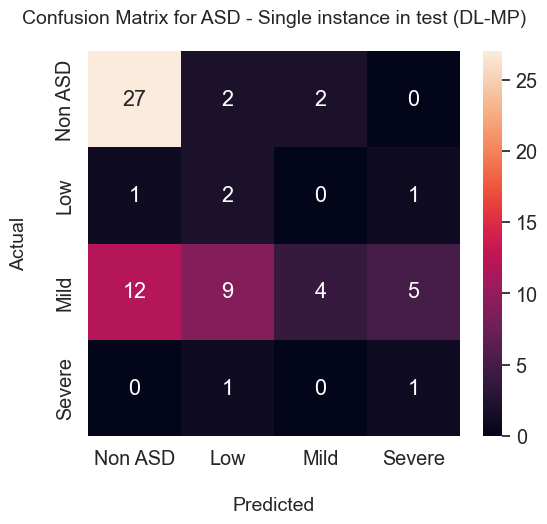

{'Accuracy': 0.833}


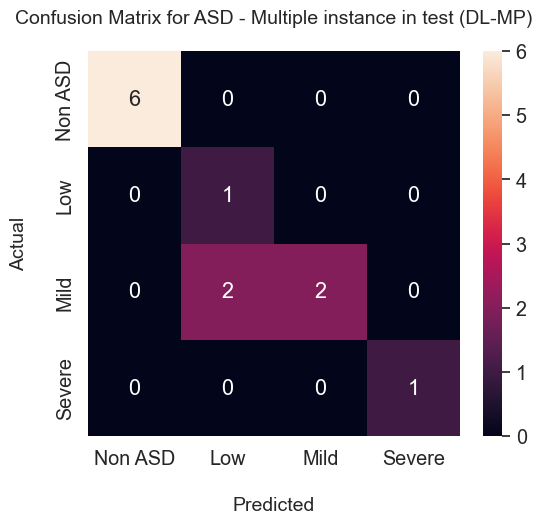

array([[6, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 2, 2, 0],
       [0, 0, 0, 1]], dtype=int64)

In [206]:
y_pred = model_multi.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

# Evaluar el modelo con la función de pérdida personalizada
#loss = custom_loss(y_test_multi_disc, y_pred)
#print(f'Custom loss: {loss}')

y_test_multi_ratio, y_pred_multi_ratio = change_MIL_multiclass(y_test_multi_disc, y_pred, IDs_test, True)
print(y_test_multi_ratio)
print(y_pred_multi_ratio)

print({"Accuracy":metrics.accuracy_score(y_test_multi_disc, y_pred).round(NDEC)})
confusion_matrix_customized(y_test_multi_disc, y_pred, "Confusion Matrix for ASD - Single instance in test (DL-MP)", CLASSES_MP)

print({"Accuracy":metrics.accuracy_score(y_test_multi_ratio, y_pred_multi_ratio).round(NDEC)})
confusion_matrix_customized(y_test_multi_ratio, y_pred_multi_ratio,
                            "Confusion Matrix for ASD - Multiple instance in test (DL-MP)", CLASSES_MP)

Sumando las probabilidades

75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step
{11: array([0.13144502, 0.05960451, 0.02773938, 0.78121108]), 20: array([0.09862546, 0.86629836, 0.0236422 , 0.01143398]), 19: array([0.0886134 , 0.86046904, 0.03106336, 0.0198542 ]), 27: array([0.02615229, 0.03642632, 0.01688427, 0.92053711]), 15: array([0.04161653, 0.02657529, 0.91485035, 0.01695783]), 17: array([0.02731462, 0.03403738, 0.02996039, 0.90868761]), 7: array([0.11098343, 0.02852932, 0.84817775, 0.0123095 ]), 13: array([0.1330426 , 0.83011444, 0.0252984 , 0.01154456]), 14: array([0.12588955, 0.8308436 , 0.02767915, 0.01558771]), 22: array([0.3724968 , 0.02315561, 0.59806334, 0.00628425]), 24: array([0.33985452, 0.03095209, 0.61471567, 0.01447773]), 10: array([0.27756407, 0.66540193, 0.03891571, 0.01811829]), 3: array([0.291506  , 0.65261389, 0.03866784, 0.01721227]), 1: array([0.24642128, 0.04369535, 0.69970935, 0.01017402]), 6: array([0.22680699, 0.72031431, 0.03523606, 0.01764264]), 2: array([0.12839359, 0.05791887, 0.01813375, 0

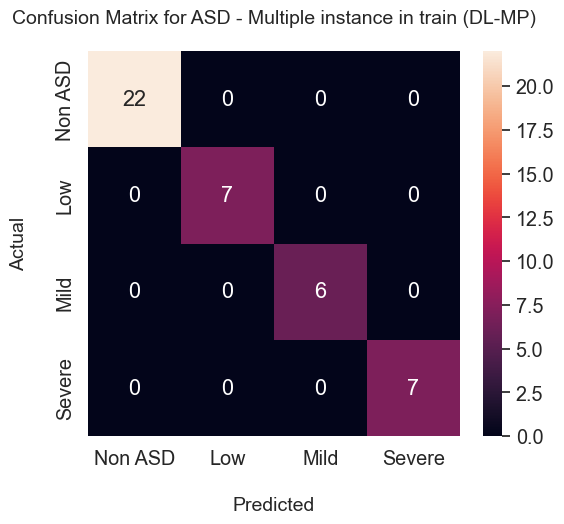

array([[22,  0,  0,  0],
       [ 0,  7,  0,  0],
       [ 0,  0,  6,  0],
       [ 0,  0,  0,  7]], dtype=int64)

In [207]:
predictions = model_multi.predict(X_train)  # Obtiene probabilidades de pertenencia a cada clase

prob_sums_by_id = {}
final_classes_by_id = {}
THRESHOLD = 0.15

# Sumar las probabilidades por ID
for pred, id in zip(predictions, IDs_train):
    if id not in prob_sums_by_id:
        prob_sums_by_id[id] = np.zeros(4)
    prob_sums_by_id[id] += pred

for id, prob_sums in prob_sums_by_id.items():
    # Normalización
    total_prob = np.sum(prob_sums)
    if total_prob != 0:
        prob_sums /= total_prob

    # Umbralización
    if prob_sums[3] >= THRESHOLD:
        final_classes_by_id[id] = 3
    elif prob_sums[2] >= THRESHOLD:
        final_classes_by_id[id] = 2
    elif prob_sums[1] >= THRESHOLD:
        final_classes_by_id[id] = 1
    else:
        final_classes_by_id[id] = 0
    #final_classes_by_id[id] = np.argmax(prob_sums)

print(prob_sums_by_id)
print(final_classes_by_id)
print(y_test_multi_ratio)

y_pred = list(final_classes_by_id.values())

print({"Accuracy":metrics.accuracy_score(y_train_multi_ratio, y_pred).round(NDEC)})
confusion_matrix_customized(y_train_multi_ratio, y_pred,
                            "Confusion Matrix for ASD - Multiple instance in train (DL-MP)", CLASSES_MP)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 
{18: array([0.1286035 , 0.32568058, 0.22219972, 0.3235162 ]), 9: array([0.12974584, 0.29912762, 0.24970406, 0.32142248]), 5: array([0.50356574, 0.29948856, 0.12506837, 0.07187733]), 8: array([0.20251086, 0.46830575, 0.10973005, 0.21945333]), 16: array([0.13352601, 0.278337  , 0.11844711, 0.46968989]), 23: array([0.6284215 , 0.16665827, 0.18439149, 0.02052874]), 31: array([0.87453433, 0.09435006, 0.02911978, 0.00199582]), 48: array([0.90497352, 0.04528334, 0.04811014, 0.001633  ]), 55: array([9.84368361e-01, 5.04345602e-03, 1.05382361e-02, 4.99466654e-05]), 53: array([0.6765128 , 0.13291479, 0.16319412, 0.02737828]), 56: array([0.92166243, 0.03870284, 0.03510196, 0.00453277]), 38: array([0.73832283, 0.11623732, 0.14043561, 0.00500425])}
{18: 3, 9: 3, 5: 1, 8: 1, 16: 3, 23: 0, 31: 0, 48: 0, 55: 0, 53: 0, 56: 0, 38: 0}
[2, 1, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0]
[2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0]
[3, 3, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0]
{'Accuracy': 0.583}


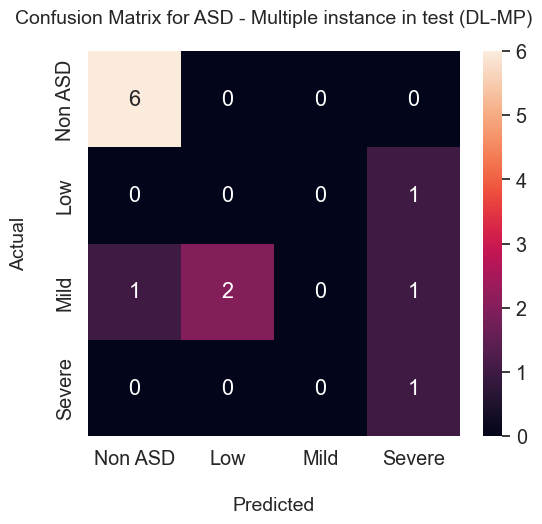

array([[6, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 2, 0, 1],
       [0, 0, 0, 1]], dtype=int64)

In [211]:
predictions = model_multi.predict(X_test)  # Obtiene probabilidades de pertenencia a cada clase

prob_sums_by_id = {}
final_classes_by_id = {}
THRESHOLD = 0.25

# Sumar las probabilidades por ID
for pred, id in zip(predictions, IDs_test):
    if id not in prob_sums_by_id:
        prob_sums_by_id[id] = np.zeros(4)
    prob_sums_by_id[id] += pred

for id, prob_sums in prob_sums_by_id.items():
    # Normalización
    total_prob = np.sum(prob_sums)
    if total_prob != 0:
        prob_sums /= total_prob

    # Umbralización
    if prob_sums[3] >= THRESHOLD:
        final_classes_by_id[id] = 3
    elif prob_sums[2] >= THRESHOLD:
        final_classes_by_id[id] = 2
    elif prob_sums[1] >= THRESHOLD:
        final_classes_by_id[id] = 1
    else:
        final_classes_by_id[id] = 0
    #final_classes_by_id[id] = np.argmax(prob_sums)
    #final_classes_by_id[id] = prob_sums[3]*3 + prob_sums[2]*2 + prob_sums[1]

print(prob_sums_by_id)
print(final_classes_by_id)
print(y_test_multi_ratio)

print(y_pred)
final_classes_by_id = thresholding_new(final_classes_by_id, [0.6, 1.2, 2.0], [0,1,2,3])
y_pred = list(final_classes_by_id.values())
print(y_pred)

print({"Accuracy":metrics.accuracy_score(y_test_multi_ratio, y_pred).round(NDEC)})
confusion_matrix_customized(y_test_multi_ratio, y_pred,
                            "Confusion Matrix for ASD - Multiple instance in test (DL-MP)", CLASSES_MP)
